In [1]:
import xml.etree.ElementTree as et
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.wsd import lesk
import re, os, string, json, statistics
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
lemmatizer = WordNetLemmatizer()
reg = re.compile(rf'(([{re.escape(string.punctuation)}]){{2,}})')

# i2b2 Data Preprocessing

In [3]:
i2b2_training_data_file = './data/i2b2/smokers_surrogate_train_all_version2.xml'
tree = et.parse(i2b2_training_data_file)
root = tree.getroot()
data = {}
total_num_of_words = 0
total_num_of_documents = 0
num_of_words_per_subset = {}
num_of_documents_per_subset = {}
num_of_words_per_document = {'number_of_words': []}
for record in root.findall('RECORD'):
    patient_id = record.get('ID')
    text = record.find('TEXT').text.split('\n')
    status = record.find('SMOKING').get('STATUS').lower()
    corpus = ''
    if status not in num_of_documents_per_subset:
        num_of_documents_per_subset[status] = 0
    num_of_documents_per_subset[status] += 1
    total_num_of_documents += 1
    total_num_of_words_per_document = 0
    for sent in text:
        row = ' '.join([lemmatizer.lemmatize(word.lower()) for word in word_tokenize(sent) if word.lower() not in stopwords_list and not reg.match(word)])
        num_of_words = len(row.split())
        corpus += re.sub("[^A-Za-z']+", ' ', str(row)).lower()
        corpus += '\n' if len(row) > 0 else ''

        if status not in num_of_words_per_subset:
            num_of_words_per_subset[status] = 0
        num_of_words_per_subset[status] += num_of_words
        total_num_of_words_per_document += num_of_words
        total_num_of_words += num_of_words
    num_of_words_per_document['number_of_words'].append(total_num_of_words_per_document)
    if status not in data:
        data[status] = []
    data[status].append({
        'id': patient_id,
        'text': corpus
    })

In [4]:
print(total_num_of_words)
print(max(num_of_words_per_document['number_of_words']))
print(min(num_of_words_per_document['number_of_words']))
print(statistics.mean(num_of_words_per_document['number_of_words']))
print(statistics.stdev(num_of_words_per_document['number_of_words']))
print(total_num_of_documents)
print(num_of_words_per_subset)
print(num_of_documents_per_subset)

175270
1644
64
440.37688442211055
290.59793073670556
398
{'current smoker': 18725, 'non-smoker': 41498, 'past smoker': 20618, 'smoker': 3596, 'unknown': 90833}
{'current smoker': 35, 'non-smoker': 66, 'past smoker': 36, 'smoker': 9, 'unknown': 252}


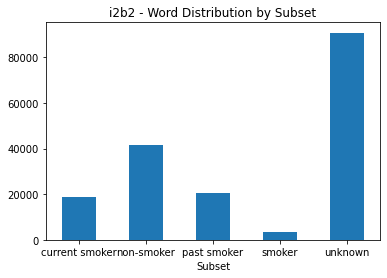

In [5]:
plt.figure()
num_of_words_distribution = pd.Series(num_of_words_per_subset, name='Number of Words')
num_of_words_distribution.index.name = 'Subset'
num_of_words_distribution.reset_index()
num_of_words_distribution.plot(kind="bar", title="i2b2 - Word Distribution by Subset")
plt.xticks(rotation='horizontal')
if not os.path.exists('./figs'):
    os.mkdir('./figs')
plt.savefig('./figs/i2b2_word_distribution.png')

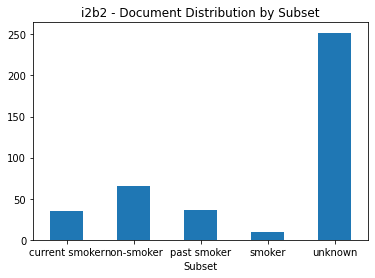

In [6]:
num_of_documents_distribution = pd.Series(num_of_documents_per_subset, name='Number of Documents')
num_of_documents_distribution.index.name = 'Subset'
num_of_documents_distribution.reset_index()
num_of_documents_distribution.plot(kind="bar", title="i2b2 - Document Distribution by Subset")
plt.xticks(rotation='horizontal')
if not os.path.exists('./figs'):
    os.mkdir('./figs')
plt.savefig('./figs/i2b2_document_distribution.png')

In [7]:
i2b2_output_dir = './data/i2b2/smokers/'
if not os.path.exists(i2b2_output_dir):
    os.mkdir(i2b2_output_dir)
    for status in data:
        if not os.path.exists(i2b2_output_dir + status):
            os.mkdir(i2b2_output_dir + status)

In [8]:
for status in data:
    for record in data[status]:
        output_file = open(i2b2_output_dir + status + '/' + record['id'] + '.txt', 'w')
        output_file.write(record['text'])
        output_file.close()

# Reuters Data Preprocessing

In [9]:
reuters_dir = './data/reuters/'
reuters_output_dir = 'processed_data'
if not os.path.exists(reuters_dir + reuters_output_dir):
    os.mkdir(reuters_dir + reuters_output_dir)

In [10]:
total_num_of_words = 0
total_num_of_documents = 0
num_of_words_per_subset = {}
num_of_documents_per_subset = {}
num_of_words_per_document = {'number_of_words': []}
for dir in os.listdir(reuters_dir):
    if dir != reuters_output_dir:
        if not os.path.exists(reuters_dir + reuters_output_dir + '/' + dir):
            os.mkdir(reuters_dir + reuters_output_dir + '/' + dir)
        for filename in os.listdir(reuters_dir + dir):
            file = open(reuters_dir + dir + '/' + filename, 'r')
            corpus = file.read().split('\n\n')
            file.close()
            if dir not in num_of_documents_per_subset:
                num_of_documents_per_subset[dir] = 0
            num_of_documents_per_subset[dir] += 1
            total_num_of_documents += 1
            total_num_of_words_per_document = 0
            prefix = corpus[0].split('\n')
            for field in prefix:
                if 'Subject:' in field:
                    prefix = field
                    break
            corpus[0] = prefix
            corpus = ' '.join(corpus)
            processed_corpus = ''
            for sent in sent_tokenize(corpus):
                row = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(sent.lower()) if word not in stopwords_list and not reg.match(word)])
                num_of_words = len(row.split())
                processed_corpus += re.sub("[^A-Za-z']+", ' ', str(row)).lower()
                processed_corpus += '\n'
                
                if dir not in num_of_words_per_subset:
                    num_of_words_per_subset[dir] = 0
                num_of_words_per_subset[dir] += num_of_words
                total_num_of_words_per_document += num_of_words
                total_num_of_words += num_of_words
            num_of_words_per_document['number_of_words'].append(total_num_of_words_per_document)
            output_file = open(reuters_dir + reuters_output_dir + '/' + dir + '/' + filename + '.txt', 'w')
            output_file.write(processed_corpus)
            output_file.close()

In [11]:
print(total_num_of_words)
print(max(num_of_words_per_document['number_of_words']))
print(min(num_of_words_per_document['number_of_words']))
print(statistics.mean(num_of_words_per_document['number_of_words']))
print(statistics.stdev(num_of_words_per_document['number_of_words']))
print(total_num_of_documents)
print(num_of_words_per_subset)
print(num_of_documents_per_subset)

392185
6701
5
165.26970080067426
337.82710298926264
2373
{'sci.crypt': 126543, 'sci.electronics': 66627, 'sci.med': 96696, 'sci.space': 102319}
{'sci.crypt': 595, 'sci.electronics': 591, 'sci.med': 594, 'sci.space': 593}


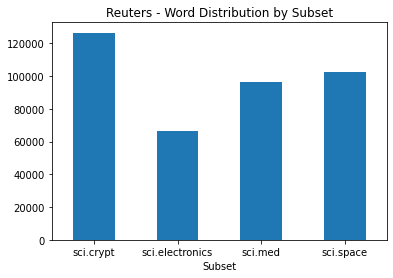

In [12]:
num_of_words_distribution = pd.Series(num_of_words_per_subset, name='Number of Words')
num_of_words_distribution.index.name = 'Subset'
num_of_words_distribution.reset_index()
num_of_words_distribution.plot(kind="bar", title="Reuters - Word Distribution by Subset")
plt.xticks(rotation='horizontal')
if not os.path.exists('./figs'):
    os.mkdir('./figs')
plt.savefig('./figs/reuters_word_distribution.png')

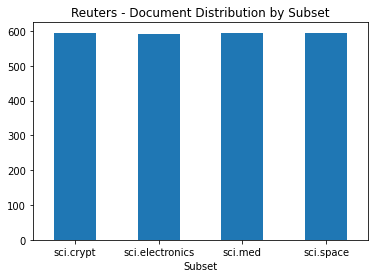

In [13]:
num_of_documents_distribution = pd.Series(num_of_documents_per_subset, name='Number of Documents')
num_of_documents_distribution.index.name = 'Subset'
num_of_documents_distribution.reset_index()
num_of_documents_distribution.plot(kind="bar", title="Reuters - Document Distribution by Subset")
plt.xticks(rotation='horizontal')
if not os.path.exists('./figs'):
    os.mkdir('./figs')
plt.savefig('./figs/reuters_document_distribution.png')

# Reddit Data Preprocessing

In [21]:
reddit_data_file = './data/reddit/reddit_data.json'
reddit_output_dir = './data/reddit/processed_data'
if not os.path.exists(reddit_output_dir):
    os.mkdir(reddit_output_dir)

In [22]:
with open(reddit_data_file) as file:
    reddit_data = json.load(file)

In [23]:
keywords_accepted_synset = {
        'smoke': ['n.02', 'n.07', 'v.01'],
        'smoker': ['n.01'],
        'smoking': ['n.01', 'v.01']
}

In [29]:
processed_reddit_data = []
total_num_of_words = 0
total_num_of_documents = 0
num_of_words_per_subset = {}
num_of_documents_per_subset = {}
for post in reddit_data:
    subreddit_name = post['subreddit']
    title = post['title'] + '.' if post['title'][-1] != '.' else post['title']
    text = post['body']
    id = post['id']
    corpus = ''
    if not os.path.exists(reddit_output_dir + '/' + subreddit_name):
        os.mkdir(reddit_output_dir + '/' + subreddit_name)
    if len(word_tokenize(text)) >= 6:
        # for keyword in keywords_accepted_synset.keys():
        #     if keyword in text:
        #         synset = lesk(text.split(), keyword)
        #         name = synset.name()
        #         if any([s in name for s in keywords_accepted_synset[keyword]]):
        if subreddit_name not in num_of_documents_per_subset:
            num_of_documents_per_subset[subreddit_name] = 0
        num_of_documents_per_subset[subreddit_name] += 1
        total_num_of_documents += 1
        total_num_of_words_per_document = 0
        for sent in sent_tokenize(text):
            row = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(sent.lower()) if word not in stopwords_list and not reg.match(word)])
            num_of_words = len(row.split())
            corpus += re.sub("[^A-Za-z']+", ' ', str(row)).lower()
            corpus += '\n' if len(row) > 0 else ''

            if subreddit_name not in num_of_words_per_subset:
                num_of_words_per_subset[subreddit_name] = 0
            num_of_words_per_subset[subreddit_name] += num_of_words
            total_num_of_words_per_document += num_of_words
            total_num_of_words += num_of_words
        num_of_words_per_document['number_of_words'].append(total_num_of_words_per_document)
        corpus = corpus.encode('ascii', 'ignore').decode('utf-8')
        output_file = open(reddit_output_dir + '/' + subreddit_name + '/' + id + '.txt', 'w')
        output_file.write(corpus)
        output_file.close()
    # else:
    #     for keyword in keywords_accepted_synset.keys():
    #         if keyword in title:
    #             synset = lesk(title.split(), keyword)
    #             name = synset.name()
    #             if any([s in name for s in keywords_accepted_synset[keyword]]):
    #                 if url and not text:
    #                     processed_text = 'url'
    #                     processed_reddit_data.append({
    #                         'subreddit': post['subreddit'],
    #                         'title': post['title'],
    #                         'url': post['url'],
    #                         'date_created': post['date_created'],
    #                         'body': processed_text
    #                     })
    #                 else:
    #                     for sent in sent_tokenize(title):
    #                         row = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(title) if word not in stopwords_list and not reg.match(word)])
    #                         processed_title += row
    #                         processed_title += '\n' if len(row) > 0 else ''
    #                     processed_reddit_data.append({
    #                         'subreddit': post['subreddit'],
    #                         'title': processed_title,
    #                         'url': post['url'],
    #                         'date_created': post['date_created'],
    #                         'body': post['body']
    #                     })
    #                 break

In [30]:
print(total_num_of_words)
print(total_num_of_documents)
print(max(num_of_words_per_document['number_of_words']))
print(min(num_of_words_per_document['number_of_words']))
print(statistics.mean(num_of_words_per_document['number_of_words']))
print(statistics.stdev(num_of_words_per_document['number_of_words']))
print(num_of_words_per_subset)
print(num_of_documents_per_subset)

193399
2393
6701
1
101.75973154362416
191.46949717741023
{'stopsmoking': 18041, 'quittingsmoking': 38270, 'QuitVaping': 67941, 'QuittingJUUL': 69147}
{'stopsmoking': 168, 'quittingsmoking': 539, 'QuitVaping': 888, 'QuittingJUUL': 798}


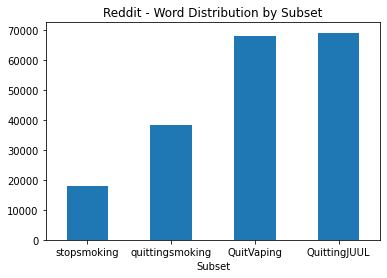

In [31]:
num_of_words_distribution = pd.Series(num_of_words_per_subset, name='Number of Words')
num_of_words_distribution.index.name = 'Subset'
num_of_words_distribution.reset_index()
num_of_words_distribution.plot(kind="bar", title="Reddit - Word Distribution by Subset")
plt.xticks(rotation='horizontal')
if not os.path.exists('./figs'):
    os.mkdir('./figs')
plt.savefig('./figs/reddit_word_distribution.png')

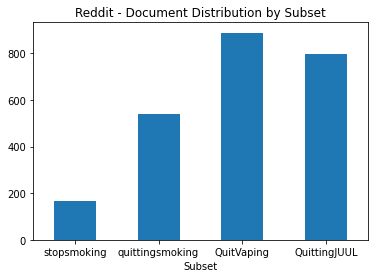

In [32]:
num_of_documents_distribution = pd.Series(num_of_documents_per_subset, name='Number of Documents')
num_of_documents_distribution.index.name = 'Subset'
num_of_documents_distribution.reset_index()
num_of_documents_distribution.plot(kind="bar", title="Reddit - Document Distribution by Subset")
plt.xticks(rotation='horizontal')
if not os.path.exists('./figs'):
    os.mkdir('./figs')
plt.savefig('./figs/reddit_document_distribution.png')